In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import itertools
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
# === USER CONFIG ===
MODEL_PATH   = 'D:\\OFFICE WORK\\KDD Summer 2025\\task3\\tumorscope\\best_model.pth'   # <-- update this
DATA_DIR     = 'dataset_sampled'          # must contain 'yes' & 'no' subfolders
BATCH_SIZE   = 32
IMG_SIZE     = 224
CLASS_NAMES  = ['no', 'yes']             # folder names/order
DEVICE       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# === 1. Data Transforms & Loader ===
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # normalize with ImageNet stats; adjust if your model used different values
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_dataset = datasets.ImageFolder(DATA_DIR, transform=test_transforms)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)

In [4]:
# === 2. Load Model ===
# Example: if you used a pretrained ResNet and fine-tuned:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # binary output
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# === 3. Inference ===
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE).float().view(-1,1)
        outputs = model(inputs)
        probs   = torch.sigmoid(outputs)
        preds   = (probs > 0.5).int()
        
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs  = np.vstack(all_probs).ravel()
all_preds  = np.vstack(all_preds).ravel()
all_labels = np.vstack(all_labels).ravel().astype(int)

In [6]:
# === 4. Classification Report & Confusion Matrix ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

          no       0.70      0.70      0.70        10
         yes       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20

Confusion Matrix:
 [[7 3]
 [3 7]]


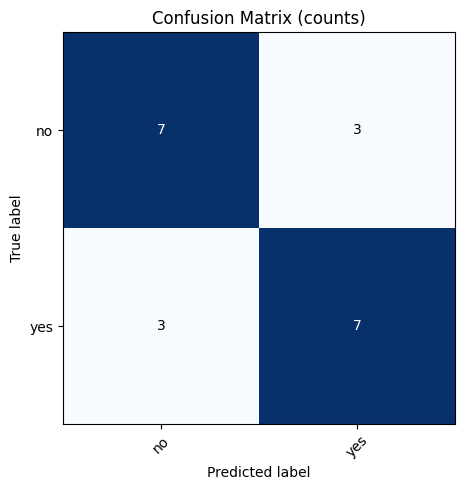

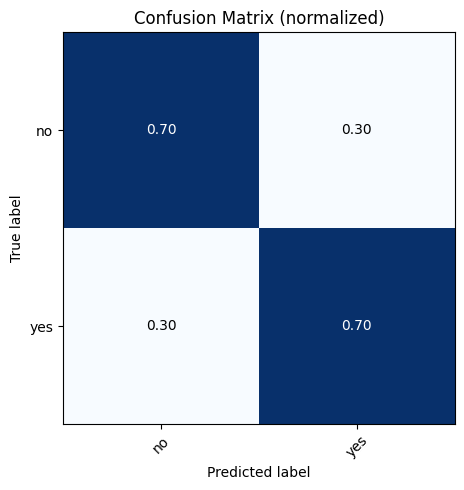

In [7]:
# === 5. Plot Confusion Matrix ===
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(5,5))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, CLASS_NAMES, normalize=False,
                      title='Confusion Matrix (counts)')
plot_confusion_matrix(cm, CLASS_NAMES, normalize=True,
                      title='Confusion Matrix (normalized)')

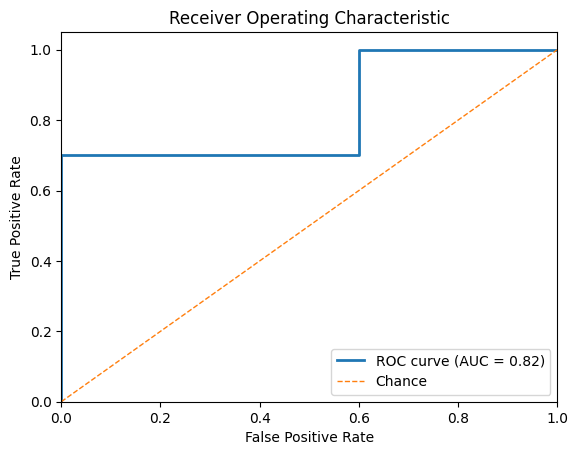

In [8]:
# === 6. ROC Curve & AUC ===
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc     = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', lw=1, label='Chance')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

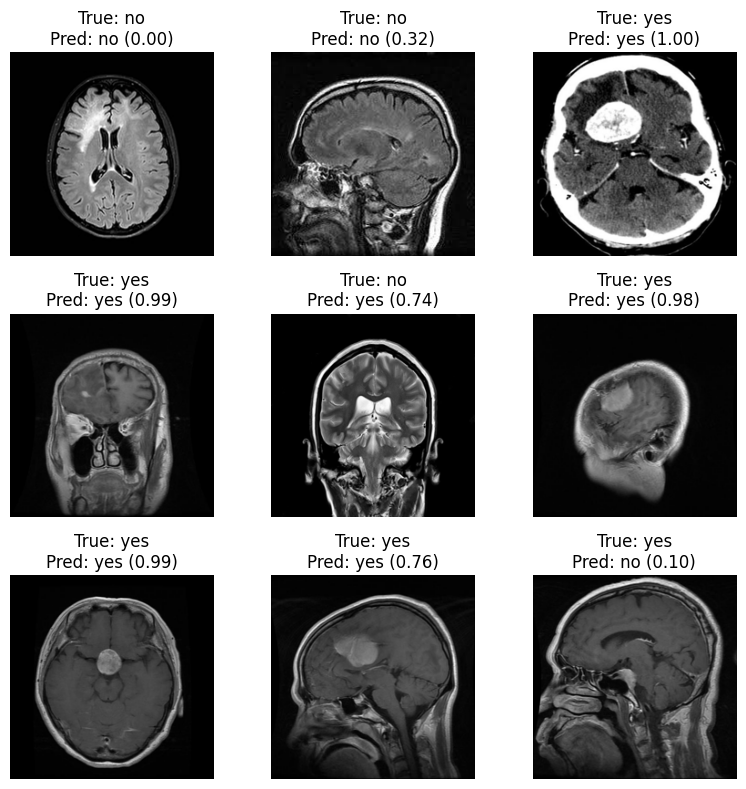

In [9]:
# === 7. Sample Predictions ===
# pick 9 random indices
indices = random.sample(range(len(test_dataset)), 9)
fig, axes = plt.subplots(3, 3, figsize=(8,8))

for ax, idx in zip(axes.flatten(), indices):
    img_path, true_label = test_dataset.samples[idx]
    img = test_dataset.loader(img_path)
    inp = test_transforms(img).unsqueeze(0).to(DEVICE)
    prob = torch.sigmoid(model(inp)).item()
    pred = 'yes' if prob > 0.5 else 'no'
    true = CLASS_NAMES[true_label]
    
    ax.imshow(np.asarray(img.resize((IMG_SIZE, IMG_SIZE))))
    ax.set_title(f'True: {true}\nPred: {pred} ({prob:.2f})')
    ax.axis('off')

plt.tight_layout()
plt.show()